# Import Module

In [1]:
from functools import partial
from hyperopt import hp
import numpy as np
import os
import pandas as pd
from ray import tune
from ray.tune.suggest.hyperopt import HyperOptSearch
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn import preprocessing
import torch
from torch import nn
from torch import optim
from torch.utils.data import TensorDataset, DataLoader

from models import AttentionRNN
from train_model import raytune_pipeline

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Data

In [3]:
train_x = pd.read_csv("./data/2_X_train.csv").drop(columns="Temp").values
train_y = pd.read_csv("./data/2_Y_train.csv").values.reshape(-1)

sequence_length = 16
num_days = int(train_x.shape[0] / sequence_length)
feature_size = train_x.shape[1]
continuous_feature_size = 8
test_size = 0.1
val_size = 0.1

train_x = train_x.reshape(num_days, sequence_length, feature_size)
train_y = train_y.reshape(num_days, sequence_length, 1)

x, test_x, y, test_y = train_test_split(train_x, train_y, test_size=test_size, train_size=(1-test_size))
train_x, val_x, train_y, val_y = train_test_split(x, y, test_size=val_size, train_size=(1-val_size))

train_num_days = train_x.shape[0]
val_num_days = val_x.shape[0]
test_num_days = test_x.shape[0]

train_x = train_x.reshape(train_num_days * sequence_length, feature_size)
val_x = val_x.reshape(val_num_days * sequence_length, feature_size)
test_x = test_x.reshape(test_num_days * sequence_length, feature_size)

ss = preprocessing.StandardScaler()
ss.fit(train_x[:, :continuous_feature_size])

train_x[:, :continuous_feature_size] = \
    ss.transform(train_x[:, :continuous_feature_size])

val_x[:, :continuous_feature_size] = \
    ss.transform(val_x[:, :continuous_feature_size])

test_x[:, :continuous_feature_size] = \
    ss.transform(test_x[:, :continuous_feature_size])

train_x = train_x.reshape(train_num_days, sequence_length, feature_size)
val_x = val_x.reshape(val_num_days, sequence_length, feature_size)
test_x = test_x.reshape(test_num_days, sequence_length, feature_size)

train_x = torch.tensor(train_x, dtype=torch.float32)
train_y = torch.tensor(train_y, dtype=torch.float32)
test_x = torch.tensor(test_x, dtype=torch.float32)
test_y = torch.tensor(test_y, dtype=torch.float32)
val_x = torch.tensor(val_x, dtype=torch.float32)
val_y = torch.tensor(val_y, dtype=torch.float32)

train_x = train_x.to(device)
train_y = train_y.to(device)
test_x = test_x.to(device)
test_y = test_y.to(device)
val_x = val_x.to(device)
val_y = val_y.to(device)

train_ds = TensorDataset(train_x, train_y)
train_loader = DataLoader(train_ds, batch_size=6, shuffle=True)

# Set Options and Config for Raytune

In [4]:
options = {
    'dataset': {'train_loader': train_loader, 'val_x': val_x, 'val_y': val_y},
    "num_epochs": 50,
    "params": {"input_size": 13, "num_layers": 1, "num_classes": 1},
    "device": device
}

In [5]:
config = {
    "lr": tune.uniform(0, 0.1),
    "hidden_size": tune.choice([25, 50, 100, 150]),
    "weight_decay": tune.choice([0, 1e-3, 1e-1]),
    "eps": tune.choice([1e-11, 1e-8, 1e-5]),
    "fc_size_0": tune.choice([50, 75, 100]),
    "fc_size_1": tune.choice([15, 25, 35]),
    "fc_size_2": tune.choice([5, 10, 20]),
}

# Parameter Optimization

In [6]:
hyperopt = HyperOptSearch(metric="mean_loss", mode="min")

In [ ]:
analysis = tune.run(
    partial(raytune_pipeline, options=options),
    config=config,
    num_samples=50,
    search_alg=hyperopt,
    resources_per_trial={'gpu':1}
)

Text(0, 0.5, 'Loss')

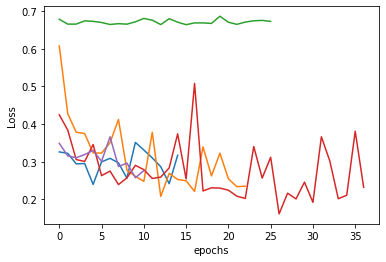

In [8]:
dfs = analysis.trial_dataframes
ax = None
for d in dfs.values():
    ax = d.mean_loss.plot(ax=ax, legend=False)
ax.set_xlabel("epochs")
ax.set_ylabel("Loss")

# Test

In [ ]:
best = analysis.get_best_config(metric="mean_loss", mode="min")
df = analysis.results_df

logdir = analysis.get_best_logdir("mean_loss", mode="min")
state_dict = torch.load(os.path.join(logdir, "rnn.pth"))

model = AttentionRNN(input_size=options["params"]["input_size"], hidden_size=best["hidden_size"],
                     num_layers=options["params"]["num_layers"], num_classes=options["params"]["num_classes"],
                     fc_sizes=[best["fc_size_0"], best["fc_size_1"], best["fc_size_2"]]).to(device)

model.load_state_dict(state_dict)

In [10]:
model.eval()
score_y = model(test_x, device).reshape(-1)
score_y = torch.sigmoid(score_y)
pred_y = torch.tensor([1 if i > 0.5 else 0 for i in score_y]).to(device)
test_y = test_y.reshape(-1)

print(sum(pred_y == test_y) / int(test_y.shape[0]))

tensor(0.9000, device='cuda:0')


In [11]:
test_y = test_y.to('cpu').detach().numpy().copy()
pred_y = pred_y.to('cpu').detach().numpy().copy()

print(classification_report(test_y, pred_y))

              precision    recall  f1-score   support

         0.0       0.88      0.77      0.82        47
         1.0       0.91      0.96      0.93       113

    accuracy                           0.90       160
   macro avg       0.89      0.86      0.87       160
weighted avg       0.90      0.90      0.90       160

